# シュレッダー復元問題の定式化

## ネットワーク定式化

### 定数とインデックス

- $R$: 縦方向の分割数
- $C$: 横方向の分割数
- $N$: 紙片の総数, $R \times C$
- $S^{x}_{ab}$: 紙片 $a$ の右に紙片 $b$ が置かれている場合の類似度
- $S^{y}_{ab}$: 紙片 $a$ の下に紙片 $b$ が置かれている場合の類似度
- $a,b \in [1,\dots,N]$: 紙片を表すインデックス

### 変数

- $x_{ab}$: 紙片 $a$ の右に紙片 $b$ が置かれている場合は $1$ となるフラグ
- $y_{ab}$: 紙片 $a$ の下に紙片 $b$ が置かれている場合は $1$ となるフラグ
- $u^{x}_{a}$: 横方向のポテンシャル
- $u^{y}_{a}$: 縦方向のポテンシャル

### 目的関数

$$
\max \sum_{ab}S^{x}_{ab}x_{ab} + \sum_{ab}S^{y}_{ab}x_{ab}
$$

### 制約条件

- $\sum_{b} x_{ab} = 1$
- $\sum_{b} x_{ba} = 1$
- $\sum_{b} y_{ab} = 1$
- $\sum_{b} y_{ba} = 1$
- $u^{x}_{a} + 1 - (N-1)(1 - x_{ab}) \leq u^{x}_{b}$
- $u^{y}_{a} + 1 - (N-1)(1 - y_{ab}) \leq u^{y}_{b}$
- $u^{x}_{a} - (N-1)(1 - y_{ab}) \leq u^{x}_{b}$
- $u^{y}_{a} - (N-1)(1 - x_{ab}) \leq u^{y}_{b}$



In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pulp

In [64]:
def load_data(path):
    with open(path, 'rb') as i_:
        return pickle.load(i_)

data = load_data('../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_30.pkl')

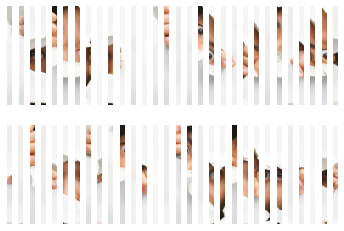

In [65]:
def show(images, rows, cols):
    fig = plt.figure()
    for i, image in enumerate(images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(image)
    fig.show()

show(data.images, data.rows, data.cols)

In [66]:
def sim_x(left, right):
    shape = np.min((left.shape, right.shape), axis=0)
    return (left[:shape[0], -1] == right[:shape[0], 0]).sum()

def sim_y(up, down):
    shape = np.min((up.shape, down.shape), axis=0)
    return (up[-1, :shape[1]] == down[0, :shape[1]]).sum()

print(sim_x(data.images[0], data.images[1]))
print(sim_y(data.images[0], data.images[1]))

357
0


In [67]:
def build_model(data):
    model = pulp.LpProblem(sense=pulp.LpMaximize)
    x = np.array(pulp.LpVariable.matrix(
        'x',
        (range(data.size + 1), range(data.size + 1)),
        cat=pulp.LpBinary
    ))
    y = np.array(pulp.LpVariable.matrix(
        'y',
        (range(data.size + 1), range(data.size + 1)),
        cat=pulp.LpBinary
    ))
    ux = np.array(pulp.LpVariable.matrix(
        'ux',
        (range(data.size),),
        lowBound=1.0,
        upBound=data.cols,
        cat=pulp.LpContinuous
    ))
    uy = np.array(pulp.LpVariable.matrix(
        'uy',
        (range(data.size),),
        lowBound=1.0,
        upBound=data.rows,
        cat=pulp.LpContinuous
    ))

    model.setObjective(pulp.lpSum(
            sim_x(data.images[a], data.images[b])*x[a, b]
            for a in range(data.size)
            for b in range(data.size)
            if a != b
        ) + pulp.lpSum(
            sim_y(data.images[a], data.images[b])*y[a, b]
            for a in range(data.size)
            for b in range(data.size)
            if a != b
        )
    )

    for a in range(data.size):
        model.addConstraint(pulp.lpSum(x[a]) - x[a, a] == 1)
        model.addConstraint(pulp.lpSum(x[:, a]) - x[a, a] == 1)
        model.addConstraint(pulp.lpSum(y[a]) - y[a, a] == 1)
        model.addConstraint(pulp.lpSum(y[:, a]) - y [a, a] == 1)

    for a in range(data.size):
        for b in range(data.size):
            if a != b:
                model.addConstraint(
                    ux[a] + 1 - (data.size - 1)*(1 - x[a, b]) <= ux[b]
                )
                model.addConstraint(
                    ux[a] - (data.size - 1)*(1 - y[a, b]) <= ux[b]
                )
                model.addConstraint(
                    uy[a] + 1 - (data.size - 1)*(1 - y[a, b]) <= uy[b]
                )
                model.addConstraint(
                    uy[a] - (data.size - 1)*(1 - x[a, b]) <= uy[b]
                )
    return model, x, y, ux, uy

model, x, y, ux, uy = build_model(data)

In [69]:
solver = pulp.PULP_CBC_CMD(timeLimit=10*60*4, threads=4)

%time model.solve(solver)

CPU times: user 471 ms, sys: 35.2 ms, total: 506 ms
Wall time: 21min 39s


1

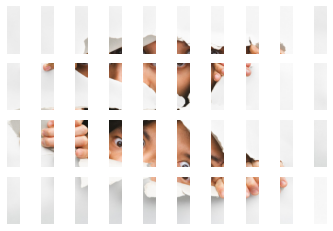

In [62]:
values = np.vectorize(lambda x: x.value())

pos = values([uy - 1, ux]).T.tolist()
show(
    [data.images[_] for _ in sorted(range(data.size), key=lambda x: pos[x])],
    data.rows,
    data.cols
)

In [70]:
model.objective.value()

26530.0